In [26]:
import sys
print(f'Working with Python {sys.version}')
import seaborn as sns
import numpy as np
import pandas as pd
import importlib
#import swifter
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import time
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import rdkit.Chem.Descriptors as Descriptors
from rdkit.Chem import PandasTools
#!pip install spektral


# Deep Learning
import sklearn
#import spektral
from sklearn.model_selection import train_test_split
# Keras
from sklearn.model_selection import train_test_split
#import stellargraph as sg
from rdkit import RDLogger


#
# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
import fiora.IO.mspReader as mspReader
import fiora.visualization.spectrum_visualizer as sv
import fiora.IO.molReader as molReader

from fiora.MOL.constants import ADDUCT_WEIGHTS
from fiora.MOL.collision_energy import align_CE
from fiora.MOL.Metabolite import Metabolite
from fiora.MOL.constants import PPM
from fiora.MOL.constants import DEFAULT_MODES
RDLogger.DisableLog('rdApp.*')


import torch
seed = 42
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)
import ast

from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree 
import fiora.visualization.spectrum_visualizer as sv
from sklearn.metrics import r2_score
import scipy

from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder

Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


In [27]:
library_name="mb_na_msms"
library_directory="../data/"
!ls $library_directory

datasplits_Feb25_25.csv		   nist_msms_filteredall_XXX.csv
datasplits_Feb25.csv		   nist_msms_filtered_min1_02_2025.csv
mb_na_msms.msp			   nist_msms_filtered_min1_XXX.csv
nist_msms_filteredall_02_2025.csv  test_A01_B23_processed.csv


In [111]:
mona_msp = mspReader.read(library_directory + library_name + '.msp')
df_mona = pd.DataFrame(mona_msp)

#df_mona['mol'] = df_mona['SMILES'].apply(Chem.MolFromSmiles)
#df_mona.dropna(inplace=True)
print(f"Spectral file loaded with {df_mona.shape[0]} entries and {df_mona.shape[1]} variables")

Spectral file loaded with 153132 entries and 17 variables


In [112]:
df_mona=df_mona.drop(index=85072)#.loc[85072,:]

In [113]:
def restore_dict(df):
    dict_columns = ["peaks"]#, "summary"]
    for col in dict_columns:
        df[col] = df[col].apply(lambda x: ast.literal_eval(str(x).replace('nan', 'None')))
    return df
df_mona=restore_dict(df_mona)
#df_mona["peaks"]
df_mona

,Name,Synon,DB#,InChIKey,Precursor_type,Spectrum_type,PrecursorMZ,Instrument_type,Instrument,Ion_mode,Collision_energy,Formula,MW,ExactMass,Comments,Num Peaks,peaks
0,Sulfaclozine,$:00in-source,AU100601,QKLPUVXBJHRFQZ-UHFFFAOYSA-N,[M+H]+,MS2,285.0208,LC-ESI-QTOF,Bruker maXis Impact,P,Ramp 21.1-31.6 eV,C10H9ClN4O2S,284,284.013474208,"""SMILES=c1cc(ccc1N)S(=O)(=O)Nc2cncc(n2)Cl"" ""ca...",27,"{'mz': [53.0389, 54.0333, 55.0178, 60.0552, 65..."
1,Sulfachlorpyridazine,$:00in-source,AU100701,XOXHILFPRYWFOD-UHFFFAOYSA-N,[M+H]+,MS2,285.0208,LC-ESI-QTOF,Bruker maXis Impact,P,Ramp 21.1-31.6 eV,C10H9ClN4O2S,284,284.013474208,"""SMILES=c1cc(ccc1N)S(=O)(=O)Nc2ccc(nn2)Cl"" ""ca...",27,"{'mz': [53.0389, 54.0333, 55.0178, 60.0552, 65..."
2,Sulfadimidine,$:00in-source,AU100801,ASWVTGNCAZCNNR-UHFFFAOYSA-N,[M+H]+,MS2,279.091,LC-ESI-QTOF,Bruker maXis Impact,P,Ramp 20.8-31.3 eV,C12H14N4O2S,278,278.083746688,"""SMILES=Cc1cc(nc(n1)NS(=O)(=O)c2ccc(cc2)N)C"" ""...",46,"{'mz': [53.0379, 54.0335, 55.0176, 65.0379, 68..."
3,Sulfamethazine,$:00in-source,AU100802,ASWVTGNCAZCNNR-UHFFFAOYSA-N,[M+H]+,MS2,279.091,LC-ESI-QTOF,Bruker maXis Impact,P,20 eV,C12H14N4O2S,278,278.083746688,"""SMILES=CC1=CC(C)=NC(NS(=O)(=O)C2=CC=C(N)C=C2)...",16,"{'mz': [122.0703, 124.0861, 125.0892, 149.0227..."
4,Sulfamethazine,$:00in-source,AU100803,ASWVTGNCAZCNNR-UHFFFAOYSA-N,[M+H]+,MS2,279.091,LC-ESI-QTOF,Bruker maXis Impact,P,30 eV,C12H14N4O2S,278,278.083746688,"""SMILES=CC1=CC(C)=NC(NS(=O)(=O)C2=CC=C(N)C=C2)...",17,"{'mz': [108.0441, 122.0704, 123.0781, 124.0861..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153127,"IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID",$:00in-source,MoNA038906,SEOVTRFCIGRIMH-SNOLXCFTSA-N,[M+H]+,MS2,181.101976,LC-ESI-QFT,Thermo Q Exactive HF,P,HCD (NCE 20-30-40%),C10H9NO2,175,175.063328528,"""computed SMILES=C1=CC2=C(C=C1)NC=C2CC(=O)O"" ""...",13,"{'mz': [81.07, 112.96664, 121.10154, 132.07764..."
153128,IS_PROGESTERONE-D9,$:00in-source,MoNA038907,RJKFOVLPORLFTN-PQIPVKAESA-N,[M+H]+,MS2,324.288376,LC-ESI-QFT,Thermo Q Exactive HF,P,HCD (NCE 20-30-40%),C21H30O2,315,315.230856946,"""computed SMILES=CC(=O)[C@@]1([2H])CC[C@H]2[C@...",68,"{'mz': [85.09495, 86.06796, 88.08373, 89.08997..."
153129,TURANOSE,$:00in-source,MoNA038909,RULSWEULPANCDV-PIXUTMIVSA-N,[M+NH4]+,MS2,360.1500345,LC-ESI-QFT,Thermo Q Exactive HF,P,HCD (NCE 20-30-40%),C12H22O11,342,342.116211524,"""computed SMILES=C([C@H]([C@H]([C@@H](C(=O)CO)...",35,"{'mz': [55.01811, 55.29488, 57.03375, 61.02862..."
153130,IS_4-HYDROXYPHENYL-D4-ALANINE,$:00in-source,MoNA038908,OUYCCCASQSFEME-FCDGGRDXSA-N,[M+H]+,MS2,186.106276,LC-ESI-QFT,Thermo Q Exactive HF,P,HCD (NCE 20-30-40%),C9H11NO3,181,181.073893212,"""computed SMILES=C1=C(C=CC(=C1)O)C[C@@H](C(=O)...",19,"{'mz': [64.84825, 66.41745, 72.71096, 88.02159..."


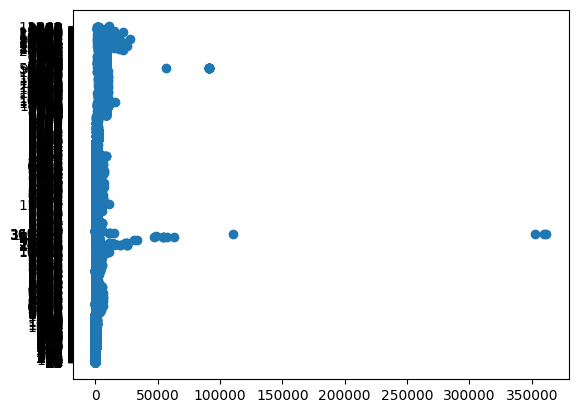

In [116]:
def count_peaks(df):
    for i in (df.index):
        df.loc[i,"Num Peaks_new"]=int(len(df.loc[i,"peaks"]["mz"]))
    return df
df_mona=count_peaks(df_mona)
plt.scatter(df_mona["Num Peaks_new"],df_mona["Num Peaks"])

In [87]:
# Filters
df_mona = df_mona[df_mona["Spectrum_type"] == "MS2"]
target_precursor_type = ["[M+H]+", "[M-H]-", "[M+H-H2O]+", "[M+Na]+"]
df_mona = df_mona[df_mona["Precursor_type"].apply(lambda ptype: ptype in target_precursor_type)]

# Formats
df_mona['PrecursorMZ'] = df_mona["PrecursorMZ"].str.replace(',', '.')
df_mona['PrecursorMZ'] = df_mona["PrecursorMZ"].astype('float')
df_mona['Num Peaks'] = df_mona["Num Peaks"].astype('int')


print(f"Spectral file filtered down to {df_mona.shape[0]} entries")

Spectral file filtered down to 114204 entries


In [88]:
print("Reading structure information in MOL format from library files (this may take a while)")
def fetch_mol(ID):
    x = df_mona.loc[ID]
    comments=x["Comments"].split()
    smiles=False
    for j in comments:
        if smiles:
            continue
        else:
            if "SMILES" in str(j):
                if str(j)[5]=="S":
                    smiles=str(j[7:-1])
                else:
                    smiles=str(j[8:-1])
    if smiles:        
        mol=Chem.MolFromSmiles(smiles)
    else: 
        mol=np.nan
        smiles=np.nan
    return mol,smiles

df_mona= df_mona[~df_mona["InChIKey"].isnull()] # Drop all without key (Not neccessarily neccesary)
MOL=[]
SMILES=[]
for i in df_mona.index:
    mol,smiles=fetch_mol(i)
   
    MOL=MOL+[mol]
    SMILES=SMILES+[smiles]
    
df_mona["MOL"] = MOL
df_mona["SMILES"]=SMILES
print(f"Successfully interpreted {sum(df_mona['MOL'].notna())} from {df_mona.shape[0]} entries. Dropping the rest.")
df_mona = df_mona[df_mona['MOL'].notna()]
#df_mona["SMILES"] = df_mona["MOL"].apply(Chem.MolToSmiles)
df_mona["InChI"] = df_mona["MOL"].apply(Chem.MolToInchi)
df_mona["K"] = df_mona["MOL"].apply(Chem.MolToInchiKey)
df_mona["ExactMolWeight"] = df_mona["MOL"].apply(Chem.Descriptors.ExactMolWt)

Reading structure information in MOL format from library files (this may take a while)
Successfully interpreted 113973 from 114175 entries. Dropping the rest.


In [89]:
correct_keys = df_mona.apply(lambda x: x["InChIKey"] == x["K"], axis=1)
s = "confirmed!" if correct_keys.all() else "not confirmed !! Attention!"
print(f"Confirming whether computed and provided InChI-Keys are correct. Result: {s} ({correct_keys.sum()/len(correct_keys):0.2f} correct)")
half_keys = df_mona.apply(lambda x: x["InChIKey"].split('-')[0] == x["K"].split('-')[0], axis=1)
s = "confirmed!" if half_keys.all() else "not confirmed !! Attention!"
print(f"Checking if main layer InChI-Keys are correct. Result: {s} ({half_keys.sum()/len(half_keys):0.3f} correct)")

print("Dropping all other.")
df_mona["matching_key"] = df_mona.apply(lambda x: x["InChIKey"] == x["K"], axis=1)
df_mona = df_mona[df_mona["matching_key"]]

print(f"Shape: {df_mona.shape}")

Confirming whether computed and provided InChI-Keys are correct. Result: not confirmed !! Attention! (0.76 correct)
Checking if main layer InChI-Keys are correct. Result: not confirmed !! Attention! (1.000 correct)
Dropping all other.
Shape: (86770, 23)


In [90]:
df_mona["ExactMolWeight"] = df_mona["MOL"].apply(Chem.Descriptors.ExactMolWt)
#df_mona=df_mona.drop(index=[85072]) #Issue with this one

In [91]:
df_unfiltered = df_mona.copy(deep=True)

In [103]:
def filter_df(df,MIN_PEAKS,MAX_PEAKS,PRECURSOR_TYPES):

    df_mona=df.copy()
    print("start",df_mona.shape)
    print(df_mona.columns)
    df_mona['Num Peaks'] = df_mona["Num Peaks"].astype('int')
    #df_mona['PrecursorMZ'] = df_mona["PrecursorMZ"].str.replace(',', '.')
    df_mona['PrecursorMZ'] = df_mona["PrecursorMZ"].astype('float')
    df_mona = df_mona[df_mona["Num Peaks"] > MIN_PEAKS]
    print(df_mona.shape)
    df_mona = df_mona[df_mona["Num Peaks"] < MAX_PEAKS] #TODO WHY MAX CUTOFF: REMOVE!!
    print(df_mona.shape)
    df_mona["theoretical_precursor_mz"] = df_mona["ExactMolWeight"] + df_mona["Precursor_type"].map(ADDUCT_WEIGHTS)
    df_mona = df_mona[df_mona["Precursor_type"].apply(lambda ptype: ptype in PRECURSOR_TYPES)]
    df_mona["precursor_offset"] = df_mona["PrecursorMZ"] - df_mona["theoretical_precursor_mz"]
    
    print(f"Shape {df_mona.shape}")
    return df_mona
#df_plus=filter_df(df_mona,2,30,["[M+H]+"])
#df_minus=filter_df(df_mona,2,30,["[M-H]-"])
df_all=filter_df(df_mona,2,30,["[M-H]-","[M+H]+"])

start (86770, 23)
Index(['Name', 'Synon', 'DB#', 'InChIKey', 'Precursor_type', 'Spectrum_type',
       'PrecursorMZ', 'Instrument_type', 'Instrument', 'Ion_mode',
       'Collision_energy', 'Formula', 'MW', 'ExactMass', 'Comments',
       'Num Peaks', 'peaks', 'MOL', 'SMILES', 'InChI', 'K', 'ExactMolWeight',
       'matching_key'],
      dtype='object')
(80210, 23)
(45722, 23)
Shape (44530, 25)


In [107]:
29442+15088
149183-35304
29442+15088
df_mona["Num Peaks"].value_counts()
df_mona["Num Peaks"].mean()

np.float64(170.95005186124237)

In [93]:
# TODO Use more Collision energy types. eg. ramps, stepped, resonant...
def CE_filtering(df):
    df_mona=df.copy()

    df_mona["CE"] = df_mona.apply(lambda x: align_CE(x["Collision_energy"], x["theoretical_precursor_mz"]), axis=1) #modules.MOL.collision_energy.align_CE) 
    df_mona["CE_type"] = df_mona["CE"].apply(type)
    df_mona["CE_derived_from_NCE"] = df_mona["Collision_energy"].apply(lambda x: "%" in str(x))
    
    
    print("Distinguish CE absolute values (eV - float) and normalized CE (in % - str format)")
    print(df_mona["CE_type"].value_counts())
    
    print("Removing all but absolute values")
    df_mona = df_mona[df_mona["CE_type"] == float]
    df_mona = df_mona[~df_mona["CE"].isnull()]
    #len(df_mona['CE'].unique())
    
    print(f'Detected {len(df_mona["CE"].unique())} unique collision energies in range from {np.min(df_mona["CE"])} to {max(df_mona["CE"])} eV')
    return df_mona
    
df_plus=CE_filtering(df_plus)

df_minus=CE_filtering(df_minus)

Distinguish CE absolute values (eV - float) and normalized CE (in % - str format)
CE_type
<class 'float'>    26747
<class 'str'>       2695
Name: count, dtype: int64
Removing all but absolute values
Detected 6133 unique collision energies in range from 0.0 to 368.84067884211237 eV
Distinguish CE absolute values (eV - float) and normalized CE (in % - str format)
CE_type
<class 'float'>    13412
<class 'str'>       1676
Name: count, dtype: int64
Removing all but absolute values
Detected 1829 unique collision energies in range from -45.0 to 375.66747212828767 eV


In [78]:
to_drop=[]
df_mona=df_plus.copy()
df_mona["Metabolite"] = df_mona["SMILES"].apply(Metabolite)
df_mona["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())
df_mona["Metabolite"].apply(lambda x: x.compute_graph_attributes())to_drop=[]
for i,name in enumerate(df_mona.index):
    try:
        df_mona.loc[name,"Metabolite"].fragment_MOL()
    except:
        to_drop=to_drop+[name]
df_plus=df_plus.drop(index=to_drop)      

ERROR (1, 2) [0] Cl


In [94]:
%%capture
def compute_graph(df):
    df_mona=df.copy()
    TOLERANCE = 200 * PPM
    df_mona["Metabolite"] = df_mona["SMILES"].apply(Metabolite)
    df_mona["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())
    df_mona["Metabolite"].apply(lambda x: x.compute_graph_attributes())
    df_mona["Metabolite"].apply(lambda x: x.fragment_MOL())
    df_mona.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=TOLERANCE), axis=1)
    return df_mona
df_plus=compute_graph(df_plus)
df_minus=compute_graph(df_minus)
df_minus

In [48]:
def match_framgments_and_peaks(df):
    df_mona=df.copy()
    df_mona["peak_matches"] = df_mona["Metabolite"].apply(lambda x: getattr(x, "peak_matches"))
    df_mona["num_peaks_matched"] = df_mona["peak_matches"].apply(len)
    
    def get_match_stats(matches, mode_count={m: 0 for m in DEFAULT_MODES}):
        num_unique, num_conflicts = 0, 0
        for mz, match_data in matches.items():
            #candidates = match_data["fragments"]
            ion_modes = match_data["ion_modes"]
            if len(ion_modes) == 1:
                num_unique += 1
            elif len(ion_modes) > 1:
                num_conflicts += 1
            for c in ion_modes:
                mode_count[c[0]] += 1
        return num_unique, num_conflicts, mode_count
    
    
    
    df_mona["match_stats"] = df_mona["peak_matches"].apply(lambda x: get_match_stats(x))
    df_mona["num_unique_peaks_matched"] = df_mona.apply(lambda x: x["match_stats"][0], axis=1)
    df_mona["num_conflicts_in_peak_matching"] = df_mona.apply(lambda x: x["match_stats"][1], axis=1)
    df_mona["match_mode_counts"] = df_mona.apply(lambda x: x["match_stats"][2], axis=1)
    u= df_mona["num_unique_peaks_matched"].sum() 
    s= df_mona["num_conflicts_in_peak_matching"].sum() 
    print(f"Total number of uniquely matched peaks: {u} , conflicts found within {s} matches ({100 * s / (u+s):.02f} %))")
    print(f"Total number of conflicting peak to fragment matches: {s}")
    
    df_mona.shape
    return df_mona
df_plus=match_framgments_and_peaks(df_mona)
#df_minus=match_framgments_and_peaks(df_minus)

AttributeError: 'NoneType' object has no attribute 'peak_matches'

In [13]:
df = pd.concat([df_plus, df_minus], axis=0)

df["Precursor_type"].value_counts()

Precursor_type
[M+H]+    25460
[M-H]-    12597
Name: count, dtype: int64

In [14]:
def add_metadata(df):
    orbitrap_nametags = ["Orbitrap"]
    qtof_nametags = ["QTOF", "LC-ESI-QTOF", "ESI-QTOF"]
    df["Instrument_type"] = df["Instrument_type"].apply(lambda x: "HCD" if x in orbitrap_nametags else "Q-TOF" if x in qtof_nametags else x)
    df["RETENTIONTIME"] = np.nan
    df["CCS"] = np.nan
    df["PPM_num"] = 50
    df["ppm_peak_tolerance"] = df["PPM_num"] * PPM
    df["lib"] = "MoNA"
    df["origin"] = "MoNA"
    df["Ionization"] = "ESI"
   
    return df
df=add_metadata(df)

In [15]:
filter_spectra = True
CE_upper_limit = 100.0
weight_upper_limit = 1000.0



metadata_key_map = {
                "name": "Name",
                "collision_energy":  "CE", 
                "instrument": "Instrument_type",
                "ionization": "Ionization",
                "precursor_mz": "PrecursorMZ",
                "precursor_mode": "Precursor_type",
                "retention_time": "RETENTIONTIME",
                "ccs": "CCS"
                }



df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

if filter_spectra:
    setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
    setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
    rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))

df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

if filter_spectra:
    num_ori = df.shape[0]
    correct_energy = df["Metabolite"].apply(lambda x: x.metadata["collision_energy"] <= CE_upper_limit and x.metadata["collision_energy"] > 1) 
    df = df[correct_energy]
    correct_weight = df["Metabolite"].apply(lambda x: x.metadata["molecular_weight"] <= weight_upper_limit)
    df = df[correct_weight]    
    print(f"Filtering spectra ({num_ori}) down to {df.shape[0]}")
    print(df["Precursor_type"].value_counts())

Filtering spectra (38057) down to 37238
Precursor_type
[M+H]+    24847
[M-H]-    12391
Name: count, dtype: int64


In [16]:
print("Assigning unique metabolite identifiers.")

metabolite_id_map = {}

for metabolite in df["Metabolite"]:
    is_new = True
    for id, other in metabolite_id_map.items():
        if metabolite == other:
            metabolite.set_id(id)
            is_new = False
            break
    if is_new:
        new_id = len(metabolite_id_map)
        metabolite.id = new_id
        metabolite_id_map[new_id] = metabolite

df["group_id"] = df["Metabolite"].apply(lambda x: x.get_id())
df["num_per_group"] = df["group_id"].map(df["group_id"].value_counts())

for i, data in df.iterrows():
    data["Metabolite"].set_loss_weight(1.0 / data["num_per_group"])
print(f"Found {len(metabolite_id_map)} unique molecular structures.")

Assigning unique metabolite identifiers.
Found 5532 unique molecular structures.


In [17]:
%%capture
df["loss_weight"] = df["Metabolite"].apply(lambda x: x.loss_weight)
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)
df["np"] = df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"])
df["npf"] = df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches_filtered"])
df["ppf"] = df["Metabolite"].apply(lambda x: x.match_stats["percent_peak_matches_filtered"])

In [18]:
df["Precursor_offset"] = df["PrecursorMZ"] - df.apply(lambda x: x["Metabolite"].ExactMolWeight + ADDUCT_WEIGHTS[x["Precursor_type"]], axis=1)
df["Precursor_abs_error"] = abs(df["Precursor_offset"])
df["Precursor_rel_error"] = df["Precursor_abs_error"] / df["PrecursorMZ"]
df["Precursor_ppm_error"] = df["Precursor_abs_error"] / (df["PrecursorMZ"] * PPM)
print((df["Precursor_ppm_error"] > df["PPM_num"]).sum(), "found with misaligned precursor. Removing these.")

df = df[df["Precursor_ppm_error"] <= df["PPM_num"]]

2966 found with misaligned precursor. Removing these.


In [19]:
df["coverage"] = df["Metabolite"].apply(lambda x: x.match_stats["coverage"])
coverage_tracker = {"counts": [], "all": [], "coverage": [], "fragment_only_coverage": [], "Precursor_type": []}

drop_index = []
for i,d in df.iterrows():
    M = d["Metabolite"]
    
    
    coverage_tracker["counts"] += [M.match_stats["counts"]]
    coverage_tracker["all"] += [M.match_stats["ms_all_counts"]]
    coverage_tracker["fragment_only_coverage"] += [M.match_stats["coverage_wo_prec"]]
    coverage_tracker["coverage"] += [M.match_stats["coverage"]]
    coverage_tracker["Precursor_type"] += [M.metadata["precursor_mode"]]
    
    
    #
    # IMPORTANT: FILTER AND CLEAN DATA
    #
    
    
    min_coverage = 0.5
    if M.match_stats["coverage"] < min_coverage: # Filter if total coverage is too low
        drop_index.append(i)
    
    min_peaks = 2
    if M.match_stats["num_peak_matches_filtered"] < min_peaks:
        drop_index.append(i)

    # Either condition is enough to keep the spectrum
    desired_peaks = 5
    desired_peak_percentage = 0.5
    extremly_high_coverage = 0.8
    if (M.match_stats["num_peak_matches_filtered"] < desired_peaks) & (M.match_stats["percent_peak_matches_filtered"] < desired_peak_percentage) & (M.match_stats["coverage"] < extremly_high_coverage):
        drop_index.append(i)

        #if M.match_stats["num_non_precursor_matches"] < 1:
        #    drop_index.append(i)
    # max_conflicts_rel = 0.75
    # if M.match_stats["rel_fragment_conflicts"] > max_conflicts_rel: 
    #     drop_index.append(i)
    
    max_precursor = 0.9
    if M.match_stats["precursor_prob"] > max_precursor: # Filter if fragment coverage is too low (intensity wise)
       drop_index.append(i)
    
    # if d["lib"] == "MSDIAL":
    #     if d["INSTRUMENTTYPE"] == "Orbitrap": # and M.match_stats["precursor_prob"] > 0.95:
    #         drop_index.append(i)
    
    
# filter low res instruments TODO update to low quality spectra
low_quality_tags = ["IT/ion trap", "QqQ", "LC-ESI-QQ", "Flow-injection QqQ/MS", "LC-APPI-QQ", "LC-ESI-IT", "LC-ESI-QIT", "QIT"] #What about ESI-ITTOF? GC-APCI-QTOF?
low_res_machines = df["Metabolite"].apply(lambda x: x.metadata["instrument"] in low_quality_tags)
drop_index += list(df[low_res_machines].index)
df.drop(drop_index, inplace=True)

In [21]:
df.to_csv("../datasplits_Feb25_test.csv")